In [ ]:
import torch
import pickle
import pandas as pd
import numpy as np
import os
os.environ["WANDB_DISABLED"] = "true"
from training import compute_metrics_QA
%load_ext autoreload
%autoreload 2

dataset_name = {}
dataset_name['fr'] = 'fquad'
dataset_name['en'] = 'squad'
data_path = '/data/desponds/data/Question_answering/'

In [ ]:
from preprocessing import preprocessing_question_answering
datasets, tokenized = preprocessing_question_answering(dataset_name, data_path)

In [ ]:
from training import get_trainers_question_answering
trainers = get_trainers_question_answering(data_path, tokenized, langs = ['en'])

In [ ]:
from training import get_models_question_answering
models = get_models_question_answering(trainers)

## Translation fr to en

In [ ]:
from translation import translate_fr_en_qa
from transformers import pipeline
import pickle
%load_ext autoreload
%autoreload 2


save_path = '/data/desponds/data/Question_answering/'
data_path_trans = "/data/desponds/data/translation_models/"
translators_paths = {}
translators_paths['t5-small-1'] = {'fr_en' : "model_t5_small_1_8_epoch_1/checkpoint-795/", 'en_fr': "en_fr_model_t5_small_1_8_epoch_1/checkpoint-795"}
translators_paths['t5-small-3'] = {'fr_en' : "model_4_4_epoch_5/checkpoint-15890/", 'en_fr': "en_fr_model_t5_small_4_4_epoch_5/checkpoint-31775"}
translators_paths['t5-base'] = {'fr_en' : "model_t5_base_4_4_epoch_3/checkpoint-12710/", 'en_fr': "en_fr_model_t5_base_4_4_epoch_3/checkpoint-19065"}

In [ ]:
#Translation from fr to en 

for name in translators_paths:
    translator = pipeline("translation", model=f"{data_path_trans}{translators_paths[name]['fr_en']}")

    translated_fr_en = datasets['fr']['validation'].map(lambda examples : translate_fr_en_qa(examples, translator), batched = True, batch_size = 512)
    with open(f'{save_path}/{name}.pickle', 'wb') as handle:
            pickle.dump(translated_fr_en, handle)

In [ ]:
translated_fr_en

## Evaluation 

In [ ]:
#Prepare dataset for evaluation
from preprocessing import preprocess_validation_examples_QA
def remove_trans(example):
    example['context'] = example['context']['translation_text']
    
    example['question'] = example['question']['translation_text']
    return example

datasets_en, tokenized_en = {}, {}
for name in translators_paths:
    with open(f'{save_path}/{name}.pickle', 'rb') as handle:
        datasets_en[name] = pickle.load(handle)
        datasets_en[name] = datasets_en[name].map(remove_trans)
        tokenized_en[name] = datasets_en[name].map(lambda examples : preprocess_validation_examples_QA(examples, 'en'), 
                                                batched=True, remove_columns=datasets['fr']["train"].column_names)

In [ ]:
saver = {} 

In [ ]:
import pickle
metrics, all_predicted_answers = {}, {}
for name in translators_paths:
    
    translator = pipeline("translation", model=f"{data_path_trans}{translators_paths[name]['en_fr']}")
    
    predictions, _, _ = models['en'].predict(tokenized_en[name])
    start_logits, end_logits = predictions
    metric, predicted_answers, theoretical_answers = compute_metrics_QA(start_logits, end_logits, 
               tokenized_en[name], datasets_en[name],
               need_translation = True, base_answers = datasets['fr']["validation"],
               translator = translator)
    
    metrics[name] = metric
    all_predicted_answers[name] = predicted_answers
with open('/data/desponds/data/Question_answering/translators_predicted_answers.pickle', 'wb') as handle:
    pickle.dump(all_predicted_answers, handle)
print(metrics)

In [ ]:
all_predicted_answers['t5-small-1']

In [83]:
import pandas as pd 
results_qa = pd.DataFrame() 

results_qa['question'] = [th['question'] for th in datasets['fr']["validation"]]
results_qa['theoretical_answers'] = [th['answers']['text'][0] for th in datasets['fr']["validation"]]
for name in translators_paths :
    results_qa[name] = [th['prediction_text'] for th in all_predicted_answers[name]]

In [85]:
results_qa[:30]

,question,theoretical_answers,t5-small-1,t5-small-3,t5-base
0,Que concerne principalement les documents ?,La Vierge aux rochers,Objekte der Spéculation für die Forscher,Objekte der Spéculation,Verdachtsobjekte
1,Par quoi sont décrit les deux tableaux ?,documents contemporains,"La Vierge zu den Rössern, aber sie bleiben Obj...",certes,certes
2,Quels types d'objets sont les deux tableaux au...,objets de spéculations,Objekte der Spéculation für die Forscher,Objekte der Spéculation,Verdachtsobjekte
3,Sur quelle jambe les personnages se tiennent-t...,droite,the characters hold en support on their jambe ...,Unterstützung auf dem rechten Bein,threw him
4,Quel pied avancent les personnages ?,gauche,"hair longs and boucles, they are vêtus",Rechtes Bein,links
5,De quelle couleur est l'ange qui joue de la li...,vert,jambe droite et avancer leur pied gauche vers ...,weiß,gris
6,D'où sont issus les deux panneaux ?,atelier de Léonard de Vinci,die beiden panneaux stammen aus Léonard von Vi...,Léonard de Vinciatelier,Werkstatt von Léonard de Vinci
7,Lors de quel processus des craquelures apparai...,séchage,"für bestimmte, sind die Ursache von Problemen",Verwendung von Fingernägeln zur Veredelung von...,Beendigung
8,Qu'est ce qui est utilisé pour la finition des...,doigts,Fingern,Fingernails,Finger
9,Quel est le nom du panneau central du retable ?,La Vierge aux rochers,La Vierge aux rochers,La Vierge zu den Felsen,Vier zu den Räubern


In [95]:
metrics = {'t5-small-1': {'exact_match': 4.736511919698871, 'f1': 10.399724902918903, 'bleu':6.0798},
 't5-small-3': {'exact_match': 8.939774153074028, 'f1': 15.967568119984543, 'bleu': 20.9125},
 't5-base': {'exact_match': 10.319949811794228, 'f1': 17.164089432704756, 'bleu': 26.0477},
 'helsinki': ({'exact_match': 29.76787, 'f1': 56.5588, 'bleu':56.3933})}

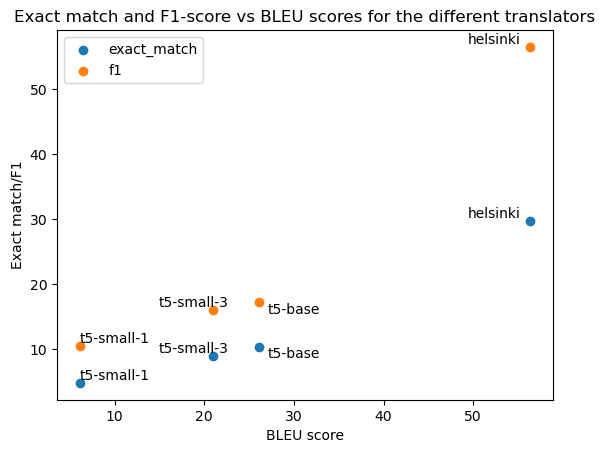

In [107]:
import matplotlib.pyplot as plt

# Sample data
exact_match = [val['exact_match'] for key, val in metrics.items()]
f1 = [val['f1'] for key, val in metrics.items()]
bleus = [val['bleu'] for key, val in metrics.items()]
names = [key for key, val in metrics.items()]
v_shift = [0,-6, 1, -7, 1, -7, -8]
v_position = ['bottom','bottom', 'top', 'bottom', 'bottom', 'top','bottom']
position = ['bottom','bottom', 'top', 'bottom', 'bottom', 'top','bottom']

# Create scatter plot
plt.scatter(bleus, exact_match, label = 'exact_match')
plt.scatter(bleus, f1, label = 'f1')
val = 0.002
# Add text annotations for names
for i, name in enumerate(names):
    plt.text(bleus[i] +v_shift[i], exact_match[i]+val if i %2 == 0 else exact_match[i]-val, name,
             ha='left', va=position[i])
    plt.text(bleus[i] +v_shift[i], f1[i]+val if i %2 == 0 else f1[i]-val, name,
             ha='left', va=position[i])

# Set plot title and labels
plt.title("Exact match and F1-score vs BLEU scores for the different translators")
plt.xlabel("BLEU score")
plt.ylabel("Exact match/F1")

# Display the plot
plt.legend()
plt.show()